# NOM Data
This notebook demonstrates a backwards traversal of the NMDC schema using NOM data. 

In [4]:
import requests
from io import StringIO
import nom_functions as func
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import itertools
import seaborn as sns

Pull all records of DataObjects with NOM processed data by pulling all DataObjects with data_object_type == “FT ICR-MS Analysis Results”. 

In [5]:
# pull all NOM data objects
processed_nom=func.get_next_results(collection='data_object_set',\
                       filter='{"data_object_type":{"$regex": "FT ICR-MS Analysis Results"}}',\
                        max_page_size=100,fields='id,url,was_generated_by')

# clarify names
for dataobject in processed_nom:
    dataobject["processed_nom_id"] = dataobject.pop("id")
    dataobject["processed_nom_url"] = dataobject.pop("url")
    dataobject["processed_nom_was_generated_by"] = dataobject.pop("was_generated_by")

# convert to df
processed_nom_df = func.convert_df(processed_nom)
processed_nom_df

,processed_nom_id,processed_nom_url,processed_nom_was_generated_by
0,nmdc:dobj-11-00dewm52,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-0mqv1c63.1
1,nmdc:dobj-11-00wm3313,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-twkd5a03.1
2,nmdc:dobj-11-01kye625,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-ftaq2319.1
3,nmdc:dobj-11-02trja88,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,nmdc:wfnom-11-2dcp9q04.1
4,nmdc:dobj-11-0312n668,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-tt4h8h18.1
...,...,...,...
2544,nmdc:dobj-13-zrp1qw41,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...,nmdc:wfnom-13-08q56295.1
2545,nmdc:dobj-13-zsqpnm92,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-yy5yqx31.1
2546,nmdc:dobj-13-zvnmsp76,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:wfnom-13-4xrsd836.1
2547,nmdc:dobj-13-zvzx2462,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-h0r53g59.1


Pull all NomAnalysis records by ID using the DataObjects’ “was_generated_by” values

In [6]:
analysis_dataobj=func.get_id_results(
                                    newest_results=processed_nom,\
                                    id_field="processed_nom_was_generated_by",\
                                    query_collection="nom_analysis_activity_set",\
                                    match_id_field="id",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in analysis_dataobj:
    dataobject["analysis_id"] = dataobject.pop("id")
    dataobject["analysis_has_input"] = dataobject.pop("has_input")
    dataobject["analysis_has_output"] = dataobject.pop("has_output")

# convert to data frame
analysis_dataobj_df = func.convert_df(analysis_dataobj)
analysis_dataobj_df





,analysis_id,analysis_has_input,analysis_has_output
0,nmdc:wfnom-11-02jbzx69.1,[nmdc:dobj-11-yxxkj687],[nmdc:dobj-11-1b31n024]
1,nmdc:wfnom-11-03jg0t92.1,[nmdc:dobj-11-kb248k07],[nmdc:dobj-11-1qd46a11]
2,nmdc:wfnom-11-0ja27676.1,[nmdc:dobj-11-sfxhy663],[nmdc:dobj-11-10hsvv22]
3,nmdc:wfnom-11-0mqv1c63.1,[nmdc:dobj-11-3hfzr472],[nmdc:dobj-11-00dewm52]
4,nmdc:wfnom-11-0psxg735.1,[nmdc:dobj-11-mm66fw14],[nmdc:dobj-11-0h1dcq11]
...,...,...,...
2544,nmdc:wfnom-13-x9zeh503.1,[nmdc:dobj-13-yscv7j32],[nmdc:dobj-13-xs2m3282]
2545,nmdc:wfnom-13-xdwkqj90.1,[nmdc:dobj-13-zjrg8w43],[nmdc:dobj-13-y8w35874]
2546,nmdc:wfnom-13-ycxczw19.1,[nmdc:dobj-13-w9czqg70],[nmdc:dobj-13-yasv1664]
2547,nmdc:wfnom-13-yy5yqx31.1,[nmdc:dobj-13-w15zk074],[nmdc:dobj-13-zsqpnm92]


Pull all DataObjects of raw NOM data by ID from using the NomAnalysis’ “has_input” values. Filter out rows of raw data objects with NaN values in metadata columns (url, was_generated_by) since these fields are required for pulling the next processing record. These are orphan data objects.

In [7]:
raw_dataobj=func.get_id_results(
                                    newest_results=analysis_dataobj,\
                                    id_field="analysis_has_input",\
                                    query_collection="data_object_set",\
                                    match_id_field="id",\
                                    query_fields="id,name,was_generated_by")

# easier to filter out NaN from a dataframe than from a list of dictionaries so convert to df first
raw_df = func.convert_df(raw_dataobj)

#filter out NaN values in "was_generated_by"
raw_dropna_df=raw_df.dropna(subset="was_generated_by")

# clarify names of filtered dataframe
raw_dropna_df=raw_dropna_df.rename(columns={"id":"raw_id","was_generated_by":"raw_was_generated_by","name":"raw_name"})

#turn filtered pandas dataframe back into list of dictionaries for next search
raw_dropna = [i.to_dict() for k, i in raw_dropna_df.iterrows()]

raw_dropna_df

,raw_id,raw_name,raw_was_generated_by
0,nmdc:dobj-11-04embv91,Lybrand_FT_62_W_23Aug19_Alder_Infuse_p3_1_01_4...,nmdc:omprc-11-adjx8k29
1,nmdc:dobj-11-04ny1n21,Lybrand_FT_36_C_30Aug19_Alder_Infuse_p05_1_01_...,nmdc:omprc-11-w1kvtj73
2,nmdc:dobj-11-09p17z03,Lybrand_Permafrost_BOG_14_CHCl3_13Dec19_Alder_...,nmdc:omprc-11-rj3bqn04
3,nmdc:dobj-11-0cmhqk17,WHONDRS_S19S_0059_ICR_1_43_Alder_Inf_13Sept19_...,nmdc:omprc-11-a1szxs11
4,nmdc:dobj-11-0rgvyp97,WHONDRS_S19S_R33_14Sept2020_Alder_Infuse_p15_1...,nmdc:omprc-11-sc2gv291
...,...,...,...
2473,nmdc:dobj-13-r4nvvk04,Rachael_21T_19-15_C_20Mar17_leopard_Infuse.raw,nmdc:omprc-13-jef2rw89
2477,nmdc:dobj-13-rwnxzx95,Rachael_21T_06-45_M_14Mar17_leopard_Infuse.raw,nmdc:omprc-13-n1jjh219
2515,nmdc:dobj-13-b28x6912,Rachael_21T_04-15A_M_03Mar17_leopard_Infuse.raw,nmdc:omprc-13-5mg3j261
2517,nmdc:dobj-13-ewk8zp52,Rachael_21T_10-15_C_20Mar17_leopard_Infuse.raw,nmdc:omprc-13-pvx2q233


Pull all OmicsProcessing records by ID using the (raw) DataObjects’ “was_generated_by”

In [8]:
omicsprocess_dataobj=func.get_id_results(
                                    newest_results=raw_dropna,\
                                    id_field="raw_was_generated_by",\
                                    query_collection="omics_processing_set",\
                                    match_id_field="id",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in omicsprocess_dataobj:
    dataobject["omicsprocess_id"] = dataobject.pop("id")
    dataobject["omicsprocess_has_output"] = dataobject.pop("has_output")
    dataobject["omicsprocess_has_input"] = dataobject.pop("has_input")
# convert to data frame
omicsprocess_dataobj_df = func.convert_df(omicsprocess_dataobj)
omicsprocess_dataobj_df


,omicsprocess_id,omicsprocess_has_output,omicsprocess_has_input
0,nmdc:omprc-11-01zxp861,[nmdc:dobj-11-rq95kp39],[nmdc:bsm-11-7pnxca42]
1,nmdc:omprc-11-0as1cf06,[nmdc:dobj-11-sr5yr197],[nmdc:bsm-11-r4kd3451]
2,nmdc:omprc-11-1n1a2m42,[nmdc:dobj-11-apa2nd57],[nmdc:bsm-11-vv3dzk35]
3,nmdc:omprc-11-2770m091,[nmdc:dobj-11-x00ktf85],[nmdc:bsm-11-7g2azz24]
4,nmdc:omprc-11-29md9e53,[nmdc:dobj-11-kzymvt20],[nmdc:bsm-11-v06w0p56]
...,...,...,...
1816,nmdc:omprc-13-pvx2q233,[nmdc:dobj-13-ewk8zp52],[nmdc:bsm-13-p9zqbp95]
1817,nmdc:omprc-13-x5ht3965,[nmdc:dobj-13-v5mwxs63],[nmdc:bsm-13-pwrd7087]
1818,nmdc:omprc-13-x8nnp113,[nmdc:dobj-13-kk307r64],[nmdc:bsm-13-zaezdc83]
1819,nmdc:omprc-13-zr3chw40,[nmdc:dobj-13-ar897938],[nmdc:bsm-13-gxb7yg84]


Pull all Biosample records by ID using the OmicsProcessing “has_input” values. HERE is where I will add in metadata about environmental triad that Bea is working on. For now adding in made up categories. 

In [9]:
biosample_dataobj=func.get_id_results(
                                    newest_results=omicsprocess_dataobj,\
                                    id_field="omicsprocess_has_input",\
                                    query_collection="biosample_set",\
                                    match_id_field="id",\
                                    query_fields="id")

# clarify names
for dataobject in biosample_dataobj:
    dataobject["biosample_id"] = dataobject.pop("id")

# convert to data frame
biosample_dataobj_df = func.convert_df(biosample_dataobj)

###MADE UP CATEGORIES
#get unique rows because some omniprocessing records may have the same biosample
sample_type_gen=pd.DataFrame(biosample_dataobj_df['biosample_id'].unique(),columns=['biosample_id'])
sample_type_gen['samp_source']=["groundwater","pond","lake","creek","river"]*198
biosample_dataobj_df=pd.merge(sample_type_gen,biosample_dataobj_df,on="biosample_id")

biosample_dataobj_df

,biosample_id,samp_source
0,nmdc:bsm-11-12esnc57,groundwater
1,nmdc:bsm-11-12esnc57,groundwater
2,nmdc:bsm-11-12esnc57,groundwater
3,nmdc:bsm-11-12esnc57,groundwater
4,nmdc:bsm-11-12esnc57,groundwater
...,...,...
1702,nmdc:bsm-13-zr9dcy94,pond
1703,nmdc:bsm-13-zxqyyz58,lake
1704,nmdc:bsm-13-zxqyyz58,lake
1705,nmdc:bsm-13-4bfysc34,creek


Build merged dataframe with results

In [10]:
#match all processed nom objects (via processed_nom_was_generated_by) to analysis objects (via analysis_id) and expand lists has_input and has_output
processed_obj_to_analysis_df=func.merge_df(processed_nom_df,analysis_dataobj_df,"processed_nom_was_generated_by","analysis_id",[],["analysis_has_input","analysis_has_output"])

#match raw data objects (via raw_id) to all_analysis_df (via analysis_has_input)
processed_obj_to_raw_df=func.merge_df(raw_dropna_df,processed_obj_to_analysis_df,"raw_id","analysis_has_input",[],[])

#match all_raw_df (via raw_was_generated_by) to omics processing objects (via omicsprocess_id) and expand lists has_input and has_output
processed_obj_to_omicsprocess_df=func.merge_df(processed_obj_to_raw_df,omicsprocess_dataobj_df,"raw_was_generated_by","omicsprocess_id",[],["omicsprocess_has_input","omicsprocess_has_output"])

#match biosample objects (via biosample_id) to all_omics_process_df (via omicsprocess_has_input)
merged_df=func.merge_df(biosample_dataobj_df,processed_obj_to_omicsprocess_df,"biosample_id","omicsprocess_has_input",[],[])

merged_df

,biosample_id,samp_source,raw_id,raw_name,raw_was_generated_by,processed_nom_id,processed_nom_url,processed_nom_was_generated_by,analysis_id,analysis_has_input,analysis_has_output,omicsprocess_id,omicsprocess_has_output,omicsprocess_has_input
0,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-gdhnkg66,1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300...,nmdc:omprc-11-wj8myx84,nmdc:dobj-11-0dyc2f79,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-xnhh0t17.1,nmdc:wfnom-11-xnhh0t17.1,nmdc:dobj-11-gdhnkg66,nmdc:dobj-11-0dyc2f79,nmdc:omprc-11-wj8myx84,nmdc:dobj-11-gdhnkg66,nmdc:bsm-11-12esnc57
1,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-vkheqz50,1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300...,nmdc:omprc-11-s2590964,nmdc:dobj-11-07gsmc68,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-r8x4ew73.1,nmdc:wfnom-11-r8x4ew73.1,nmdc:dobj-11-vkheqz50,nmdc:dobj-11-07gsmc68,nmdc:omprc-11-s2590964,nmdc:dobj-11-vkheqz50,nmdc:bsm-11-12esnc57
2,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-qt6pmm77,1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300...,nmdc:omprc-11-6mbfsz04,nmdc:dobj-11-jj2r0a49,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-edr3rn40.1,nmdc:wfnom-11-edr3rn40.1,nmdc:dobj-11-qt6pmm77,nmdc:dobj-11-jj2r0a49,nmdc:omprc-11-6mbfsz04,nmdc:dobj-11-qt6pmm77,nmdc:bsm-11-12esnc57
3,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-z002ga43,1000S_WLUP_FTMS_SPE_TOP_2_run2_Fir_22Apr22_300...,nmdc:omprc-11-6ejjgv07,nmdc:dobj-11-mmdwds36,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-zr24j979.1,nmdc:wfnom-11-zr24j979.1,nmdc:dobj-11-z002ga43,nmdc:dobj-11-mmdwds36,nmdc:omprc-11-6ejjgv07,nmdc:dobj-11-z002ga43,nmdc:bsm-11-12esnc57
4,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-hdd01t09,1000S_WLUP_FTMS_SPE_TOP_1_run1_Fir_22Apr22_300...,nmdc:omprc-11-mcataq54,nmdc:dobj-11-s42fww29,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-befkpb58.1,nmdc:wfnom-11-befkpb58.1,nmdc:dobj-11-hdd01t09,nmdc:dobj-11-s42fww29,nmdc:omprc-11-mcataq54,nmdc:dobj-11-hdd01t09,nmdc:bsm-11-12esnc57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228,nmdc:bsm-13-4bfysc34,creek,nmdc:dobj-13-xx781m34,Rachael_21T_04-15A_M_14Mar17_leopard_Infuse.raw,nmdc:omprc-13-4wkf0639,nmdc:dobj-13-nxv2mc44,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-jr6ae044.1,nmdc:wfnom-13-jr6ae044.1,nmdc:dobj-13-xx781m34,nmdc:dobj-13-nxv2mc44,nmdc:omprc-13-4wkf0639,nmdc:dobj-13-xx781m34,nmdc:bsm-13-4bfysc34
5229,nmdc:bsm-13-4bfysc34,creek,nmdc:dobj-13-zjmw5b65,Rachael_21T_04-15A_C_20Mar17_leopard_Infuse.raw,nmdc:omprc-13-ac83x014,nmdc:dobj-13-ndcybr82,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-mc9n1t16.1,nmdc:wfnom-13-mc9n1t16.1,nmdc:dobj-13-zjmw5b65,nmdc:dobj-13-ndcybr82,nmdc:omprc-13-ac83x014,nmdc:dobj-13-zjmw5b65,nmdc:bsm-13-4bfysc34
5230,nmdc:bsm-13-4bfysc34,creek,nmdc:dobj-13-b28x6912,Rachael_21T_04-15A_M_03Mar17_leopard_Infuse.raw,nmdc:omprc-13-5mg3j261,nmdc:dobj-13-xstcrm22,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-eb5f8063.1,nmdc:wfnom-13-eb5f8063.1,nmdc:dobj-13-b28x6912,nmdc:dobj-13-xstcrm22,nmdc:omprc-13-5mg3j261,nmdc:dobj-13-b28x6912,nmdc:bsm-13-4bfysc34
5231,nmdc:bsm-13-tk2ebg43,river,nmdc:dobj-13-p6nbwp18,Rachael_21T_19-15_M_14Mar17_leopard_Infuse.raw,nmdc:omprc-13-dsva8j03,nmdc:dobj-13-n2g0fg49,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-2w27bd07.1,nmdc:wfnom-13-2w27bd07.1,nmdc:dobj-13-p6nbwp18,nmdc:dobj-13-n2g0fg49,nmdc:omprc-13-dsva8j03,nmdc:dobj-13-p6nbwp18,nmdc:bsm-13-tk2ebg43


In [11]:
##QUESTION: why is there a duplicate processed nom url??? different nom_ids

duplicates=merged_df[merged_df.duplicated('processed_nom_url')]
prob_url=duplicates['processed_nom_url'].iloc[1]

#.duplicates doesn't pull first match so:
all_dupes=merged_df[(merged_df['processed_nom_url']==prob_url)].drop(['samp_source'],axis=1)
#all_dupes.to_csv("/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/second_omics_type/duplicate_url_info.csv")

output=[]
for id in all_dupes['biosample_id']:
    base_url = "https://api.microbiomedata.org"
    url = f"{base_url}/biosamples/{id}"
    resp = requests.get(url)
    data = resp.json()
    output.append(data)
dupe_biosample_allinfo=func.convert_df(output)
dupe_biosample_allinfo.to_csv("/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/second_omics_type/dupe_biosample_allinfo.csv")


##RESOLVED: per Katherine we should remove these processed nom data sets
merged_df=merged_df.drop(merged_df[merged_df['processed_nom_url']==prob_url].index)


Clean up final dataframe, removing unneeded intermediate ID columns.

In [12]:
column_list = merged_df.columns.tolist()
columns_to_keep = ["biosample_id","processed_nom_id","processed_nom_url","samp_source"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))
# Drop unnecessary columns
merged_df_cleaned = merged_df.drop(columns=columns_to_remove)

# remove duplicates
merged_df_cleaned.drop_duplicates(keep="first", inplace=True)

# check rows when we reagrregate/implode, 
final_df = merged_df_cleaned.groupby(["biosample_id","processed_nom_id","samp_source"]).agg({"processed_nom_url": list}).reset_index()

#convert url into string
final_df["processed_nom_url"] = final_df["processed_nom_url"].apply(lambda x: ', '.join(map(str, x)))
final_df


,biosample_id,processed_nom_id,samp_source,processed_nom_url
0,nmdc:bsm-11-01bbrr08,nmdc:dobj-11-hgk6yw09,river,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
1,nmdc:bsm-11-01jah904,nmdc:dobj-11-yckycq51,pond,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
2,nmdc:bsm-11-01vt2q72,nmdc:dobj-11-nwbr1695,lake,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
3,nmdc:bsm-11-03dy0348,nmdc:dobj-11-68pygy27,groundwater,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
4,nmdc:bsm-11-03dy0348,nmdc:dobj-11-e5mxyn30,groundwater,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...,...
1813,nmdc:bsm-13-zr9dcy94,nmdc:dobj-13-4k8vqy39,pond,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
1814,nmdc:bsm-13-zr9dcy94,nmdc:dobj-13-5f09m942,pond,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
1815,nmdc:bsm-13-zxqyyz58,nmdc:dobj-13-hy6n1463,lake,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
1816,nmdc:bsm-13-zxqyyz58,nmdc:dobj-13-j0nwnf78,lake,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...


Calculate QC stats for processed nom data (takes a while to run). confidence scores, % peaks assigned, # peaks assigned, # peaks found

In [13]:
errors = {}
iteration_counter = 0
test_final_df=final_df[:100]
output=[]

for index, row in test_final_df.iterrows():

    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")
    
    url = row["processed_nom_url"]
    biosample = row["biosample_id"]
    processed=row['processed_nom_id']
    samp_source=row['samp_source']

    try:
        #get file results
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        csv_data.close()

        #calculate stats and gather molecular formulas that were identified
        median_cs=csv_df['Confidence Score'].median()
        #above excludes nan values!! change if wanted
        unassigned=csv_df['Molecular Formula'].isnull().sum()
        assigned=csv_df['Molecular Formula'].count()
        assigned_perc=assigned/(unassigned+assigned)
        mol_form=csv_df["Molecular Formula"].unique()

        # Add stats as dictionary to output list (list of dicts)
        output.append({'biosample':biosample,'samp_source':samp_source,'processed':processed,'url':url,'median_cs':median_cs,'unassigned':unassigned,'assigned':assigned,'assigned_perc':assigned_perc,'mol_formulas':mol_form})
 
    except Exception as e:
        print(f"An error occurred: {e}")
        errors["biosample_id"] = biosample
        errors["url"] = url
        continue

qc_summary=pd.DataFrame(output)

Processed 50 rows
Processed 100 rows


Quality Control Plots

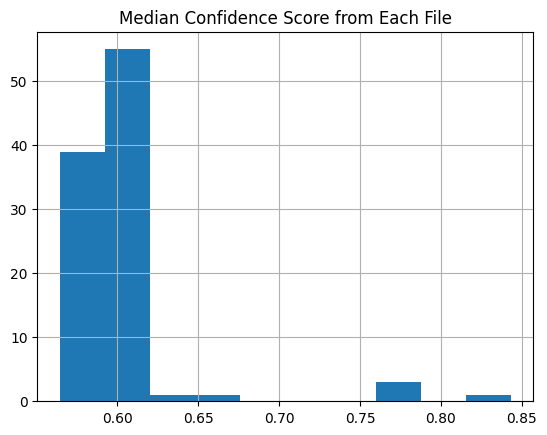

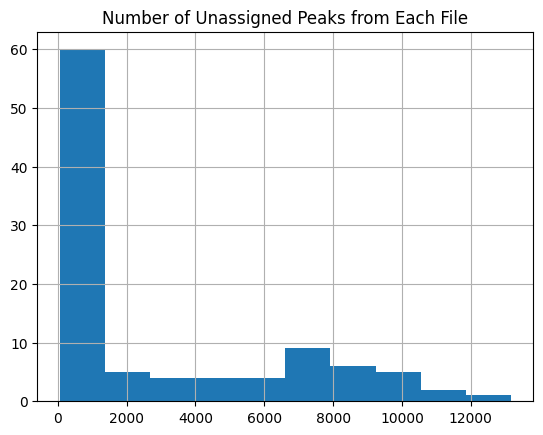

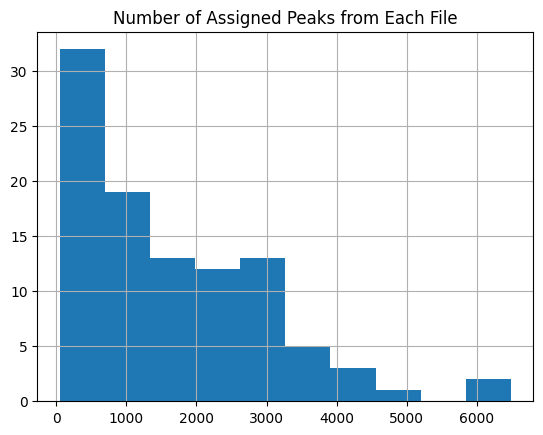

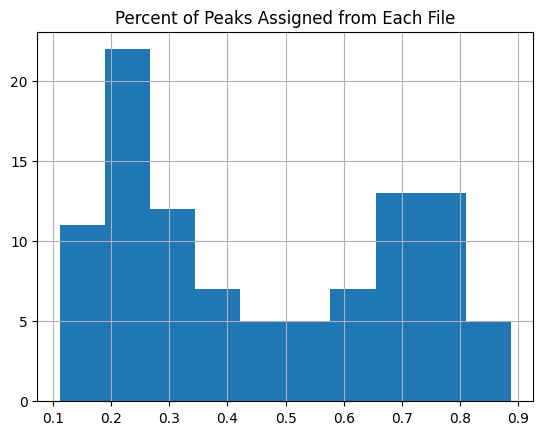

In [14]:
#histograms
qc_summary.hist("median_cs")
plt.title('Median Confidence Score from Each File')
plt.show()

qc_summary.hist("unassigned")
plt.title('Number of Unassigned Peaks from Each File')
plt.show()

qc_summary.hist("assigned")
plt.title('Number of Assigned Peaks from Each File')
plt.show()

qc_summary.hist("assigned_perc")
plt.title('Percent of Peaks Assigned from Each File')
plt.show()


In [15]:

#pairwise analysis (slide 6)
#% overlap for molecular formula to see what samples are most similar or most different

#indexed comparisons
comparisons=list(itertools.combinations(range(len(qc_summary)), 2))
pairwise_output=[]

#order dataframe for comparisons for ease of visualization with heatmap
qc_summary=qc_summary.sort_values(by=['processed'])

for comparison in comparisons:

    index1=comparison[0]
    index2=comparison[1]

    #info
    biosample1=qc_summary['biosample'].iloc[index1]
    samp_source1=qc_summary['samp_source'].iloc[index1]
    processed1=qc_summary['processed'].iloc[index1]
    biosample2=qc_summary['biosample'].iloc[index2]
    samp_source2=qc_summary['samp_source'].iloc[index2]
    processed2=qc_summary['processed'].iloc[index2]
    mol_form1=qc_summary['mol_formulas'].iloc[index1]
    mol_form2=qc_summary['mol_formulas'].iloc[index2]

    #check how many elements in mol_form1 are in mol_form2
    same=0
    same_list=[]
    for formula in mol_form1:
        for formula_comp in mol_form2:
            if formula==formula_comp:
                same=same+1
                same_list.append(formula)
    
    bio1_perc_shared=(same/len(mol_form1))*100
    bio2_perc_shared=(same/len(mol_form2))*100
    
    pairwise_output.append({'biosample1':biosample1,"samp_source1":samp_source1,'processed1':processed1,'biosample2':biosample2,"samp_source2":samp_source2,'processed2':processed2,\
                            'shared_count':same,'bio1_perc_shared':bio1_perc_shared,'bio2_perc_shared':bio2_perc_shared,\
                                'avg_perc_shared':(bio1_perc_shared+bio2_perc_shared)/2,'shared_list':same_list})

pairwise_df=pd.DataFrame(pairwise_output)

pairwise_df.sort_values(by=['shared_count'],ascending=False)



,biosample1,samp_source1,processed1,biosample2,samp_source2,processed2,shared_count,bio1_perc_shared,bio2_perc_shared,avg_perc_shared,shared_list
146,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-0dyc2f79,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-jj2r0a49,6077,94.173253,93.737467,93.955360,"[C7 H6 O2, C6 H6 O3, C6 H8 O3, C7 H12 O2, C6 H..."
144,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-0dyc2f79,nmdc:bsm-11-17yggv08,groundwater,nmdc:dobj-11-j12q5164,3891,60.297536,96.863331,78.580433,"[C7 H6 O2, C6 H8 O3, C7 H12 O2, C6 H10 O3, C5 ..."
3573,nmdc:bsm-11-17yggv08,groundwater,nmdc:dobj-11-j12q5164,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-jj2r0a49,3890,96.838437,60.003085,78.420761,"[C7 H6 O2, C6 H8 O3, C7 H12 O2, C5 H6 O4, C6 H..."
162,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-0dyc2f79,nmdc:bsm-11-03dy0348,groundwater,nmdc:dobj-11-n71xxy49,2842,44.041531,90.885833,67.463682,"[C6 H10 O3, C5 H10 O3 13C1, C5 H8 O4, C6 H12 O..."
3719,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-jj2r0a49,nmdc:bsm-11-168xmm55,creek,nmdc:dobj-11-ya2at455,2840,43.806880,61.618572,52.712726,"[C6 H10 O3, C6 H4 O5, C7 H10 O4, C8 H14 O3, C9..."
...,...,...,...,...,...,...,...,...,...,...,...
2781,nmdc:bsm-11-11avmz59,river,nmdc:dobj-11-d235fn26,nmdc:bsm-11-12esnc57,groundwater,nmdc:dobj-11-s42fww29,0,0.000000,0.000000,0.000000,[]
599,nmdc:bsm-11-0806bb27,creek,nmdc:dobj-11-4xesp402,nmdc:bsm-11-15q6wv37,river,nmdc:dobj-11-bfd5by95,0,0.000000,0.000000,0.000000,[]
2783,nmdc:bsm-11-11avmz59,river,nmdc:dobj-11-d235fn26,nmdc:bsm-11-0b67sr13,groundwater,nmdc:dobj-11-sr0m4n09,0,0.000000,0.000000,0.000000,[]
588,nmdc:bsm-11-0806bb27,creek,nmdc:dobj-11-4xesp402,nmdc:bsm-11-1dzc3x98,creek,nmdc:dobj-11-7hsagw78,0,0.000000,0.000000,0.000000,[]


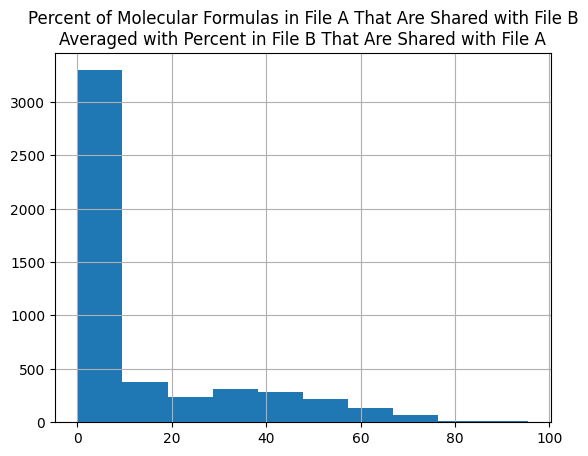

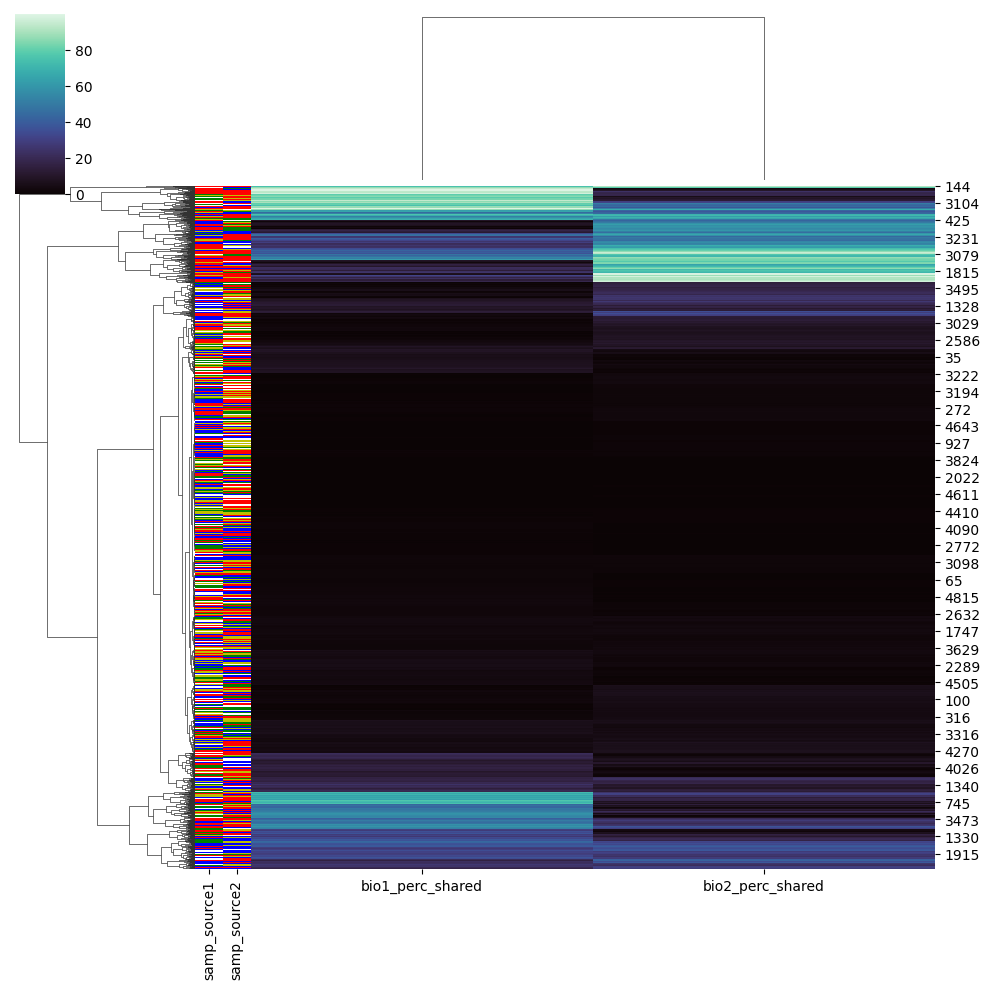

In [88]:
pairwise_df.hist("avg_perc_shared")
plt.title('Percent of Molecular Formulas in File A That Are Shared with File B\nAveraged with Percent in File B That Are Shared with File A')
plt.show()

heatmap_data=pairwise_df[["samp_source1","samp_source2","bio1_perc_shared","bio2_perc_shared"]]
samp_source1 = heatmap_data.pop("samp_source1")
lut1 = dict(zip(samp_source1.unique(), "rbgy"))
row_colors1 = samp_source1.map(lut1)
samp_source2 = heatmap_data.pop("samp_source2")
lut2 = dict(zip(samp_source2.unique(), "rbgy"))
row_colors2 = samp_source2.map(lut2)
row_colors = pd.concat([row_colors1,row_colors2],axis=1)
sns.clustermap(heatmap_data, row_colors=row_colors, cmap="mako")


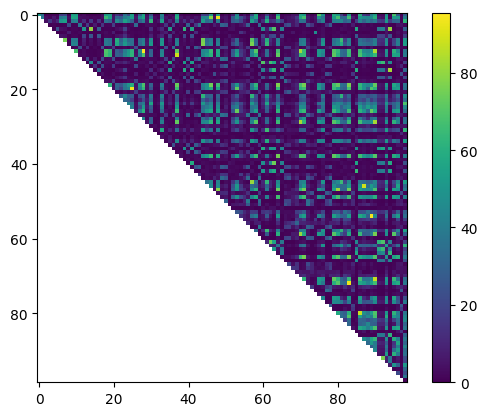

In [89]:
pairwise_matrix=pairwise_df.pivot(index='processed1',columns='processed2',values='avg_perc_shared')

plt.imshow(pairwise_matrix)
plt.colorbar()
plt.show()

In [72]:
#Van Krevelen diagram
#tsv_ex_df.scatter(x='O/C', y='H/C')



100